更新b的

In [1]:
import math
import torch
import pickle
import torch.cuda
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as dsets
import os
from utils.BBBConvmodel import BBBAlexNet, BBBLeNet, BBB3Conv3FC, BBBVGG16
from utils.BBBlayers import GaussianVariationalInference
import numpy as np
from scipy.stats import norm, cauchy
cuda = torch.cuda.is_available()
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
import math
import io
import gzip
import bz2
import lzma

In [2]:
batch_size = 32
lr = 0.001
dataset = 'CIFAR-10'
network = 'lenet'
epoch = 50
if epoch != 50:
    model = torch.load("../results/{}_b{}_lr{}epoch{}_{}.pth".format(network, batch_size, lr, epoch, dataset))
else:
    model = torch.load("../results/{}_b{}_lr{}_{}.pth".format(network, batch_size, lr, dataset))
net = BBBLeNet
num_samples = 10
beta_type = "Blundell"

In [3]:
# dimensions of input and output
if dataset == 'MNIST':    # train with MNIST
    outputs = 10
    inputs = 1
elif dataset == 'CIFAR-10':  # train with CIFAR-10
    outputs = 10
    inputs = 3
elif dataset == 'CIFAR-100':    # train with CIFAR-100
    outputs = 100
    inputs = 3

if net == BBBLeNet or BBB3Conv3FC:
    resize = 32
elif net == BBBAlexNet:
    resize = 227

In [4]:
'''
LOADING DATASET
'''

if dataset == 'MNIST':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = dsets.MNIST(root="data", download=True, transform=transform)
    val_dataset = dsets.MNIST(root="data", download=True, train=False, transform=transform)

elif dataset == 'CIFAR-100':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR100(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR100(root='data', download=True, train=False, transform=transform)

elif dataset == 'CIFAR-10':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR10(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR10(root='data', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loader_val = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model.state_dict().keys()

odict_keys(['conv1.qw_mean', 'conv1.qw_logvar', 'conv1.qb_mean', 'conv1.qb_logvar', 'conv1.conv_qw_mean', 'conv1.conv_qw_si', 'conv1.log_alpha', 'conv2.qw_mean', 'conv2.qw_logvar', 'conv2.qb_mean', 'conv2.qb_logvar', 'conv2.conv_qw_mean', 'conv2.conv_qw_si', 'conv2.log_alpha', 'fc1.qw_mean', 'fc1.qw_logvar', 'fc1.qb_mean', 'fc1.qb_logvar', 'fc1.fc_qw_mean', 'fc1.fc_qw_si', 'fc1.log_alpha', 'fc2.qw_mean', 'fc2.qw_logvar', 'fc2.qb_mean', 'fc2.qb_logvar', 'fc2.fc_qw_mean', 'fc2.fc_qw_si', 'fc2.log_alpha', 'fc3.qw_mean', 'fc3.qw_logvar', 'fc3.qb_mean', 'fc3.qb_logvar', 'fc3.fc_qw_mean', 'fc3.fc_qw_si', 'fc3.log_alpha', 'layers.0.qw_mean', 'layers.0.qw_logvar', 'layers.0.qb_mean', 'layers.0.qb_logvar', 'layers.0.conv_qw_mean', 'layers.0.conv_qw_si', 'layers.0.log_alpha', 'layers.3.qw_mean', 'layers.3.qw_logvar', 'layers.3.qb_mean', 'layers.3.qb_logvar', 'layers.3.conv_qw_mean', 'layers.3.conv_qw_si', 'layers.3.log_alpha', 'layers.7.qw_mean', 'layers.7.qw_logvar', 'layers.7.qb_mean', 'layers

# 合并weights

In [9]:
if network == "lenet" or network == "lenet5":
    w_name = ['layers.0.qw_', 'layers.3.qw_', 'layers.7.qw_','layers.9.qw_', 'layers.11.qw_']
    b_name = ['layers.0.qb_', 'layers.3.qb_', 'layers.7.qb_','layers.9.qb_', 'layers.11.qb_']
elif network == "vgg16":
    w_name = ['layers.0.qw_', 'layers.2.qw_', 'layers.4.qw_','layers.6.qw_', 'layers.8.qw_', 
              'layers.10.qw_', 'layers.12.qw_', 'layers.14.qw_', 'layers.16.qw_', 'layers.18.qw_',
            'layers.20.qw_', 'layers.22.qw_', 'layers.24.qw_', 'layers.27.qw_', 'layers.30.qw_', 'layers.33.qw_']
    b_name = ['layers.0.qb_', 'layers.2.qb_', 'layers.4.qb_','layers.6.qb_', 'layers.8.qb_', 
              'layers.10.qb_', 'layers.12.qb_', 'layers.14.qb_', 'layers.16.qb_', 'layers.18.qb_',
            'layers.20.qb_', 'layers.22.qb_', 'layers.24.qb_', 'layers.27.qb_', 'layers.30.qb_', 'layers.33.qb_']

In [8]:
model = model.cpu()

In [10]:
whole_w = []
for (i, j) in zip(w_name, b_name):
# for i in w_name:
    whole_w.append(model.state_dict()['{}mean'.format(i)].numpy().ravel())
    whole_w.append(model.state_dict()['{}mean'.format(j)].numpy().ravel())
whole_w = np.concatenate(whole_w)

In [11]:
len(whole_w)

62006

In [12]:
len(whole_w[np.abs(whole_w) <= 1e-2])

7562

# 神经网络精度计算函数

In [13]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())

def run_epoch(loader, epoch, is_training=False, model=model):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []
    likelihoods = []
    kls = []
    losses = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)
        x = images.view(-1, inputs, resize, resize)
        y = labels
        if cuda:
            x = x.cuda()
            y = y.cuda()

        if beta_type == "Blundell":
            beta = 2 ** (m - (i + 1)) / (2 ** m - 1)
        elif beta_type == "Soenderby":
            beta = min(epoch / (num_epochs//4), 1)
        elif beta_type == "Standard":
            beta = 1 / m
        else:
            beta = 0

        logits, kl = model.probforward(x)
        loss = vi(logits, y, kl, beta)
        ll = -loss.data.mean() + beta*kl.data.mean()

        if is_training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        _, predicted = logits.max(1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)
        losses.append(loss.data.mean())
        kls.append(beta*kl.data.mean())
        likelihoods.append(ll)

    diagnostics = {'loss': sum(losses)/len(losses),
                   'acc': sum(accuracies)/len(accuracies),
                   'kl': sum(kls)/len(kls),
                   'likelihood': sum(likelihoods)/len(likelihoods)}

    return diagnostics

In [14]:
model = model.cuda()
diagnostics_val = run_epoch(loader_val, epoch=1)

logits tensor([[-2.1493e+00, -3.2003e+00,  7.0649e-01,  3.1140e+00, -2.1450e+00,
          2.9329e+00,  1.0991e+00, -4.7217e-01, -4.0811e-01, -2.7547e+00],
        [ 4.0197e+00,  3.9718e+00, -1.6941e+00, -5.1676e+00, -3.6609e+00,
         -5.2027e+00, -6.0936e+00, -5.5920e+00,  7.0393e+00,  1.3131e+00],
        [ 2.2158e+00,  2.0871e+00, -1.7188e+00, -2.1081e+00, -3.3456e+00,
         -2.7486e+00, -4.3347e+00, -2.2449e+00,  3.3697e+00,  1.5962e+00],
        [ 4.8586e+00,  1.9196e-02,  1.8621e+00, -1.8592e+00, -2.2786e+00,
         -3.4586e+00, -2.6942e+00, -5.7413e+00,  4.8535e+00, -1.5377e+00],
        [-4.3069e+00, -3.2697e+00,  9.2592e-01,  1.8767e+00,  3.5506e+00,
          1.3667e+00,  2.6081e+00, -1.0409e+00, -4.4214e+00, -3.4846e+00],
        [-1.3576e+00, -4.6189e+00,  7.6176e-01,  9.0390e-01,  4.6525e-01,
          8.3169e-01,  3.4340e+00,  2.3129e-02, -4.6329e+00, -3.2040e+00],
        [ 1.4612e+00,  2.7180e+00,  6.5530e-01,  5.9821e-01, -4.0586e+00,
         -7.7937e-02, -8.

In [15]:
diagnostics_val

{'loss': tensor(311.0125, device='cuda:0'),
 'acc': tensor(0.6030),
 'kl': tensor(309.8726, device='cuda:0'),
 'likelihood': tensor(-1.1399, device='cuda:0')}

In [16]:
def evaluate(loader, cpr_model, epoch=1):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)

        x = images.view(-1, inputs, resize, resize)
        y = labels

        if cuda:
            x = x.cuda()
            y = y.cuda()

        logits = cpr_model(x)
        _, predicted = torch.max(logits.data, 1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)

    diagnostics = {'acc': sum(accuracies)/len(accuracies)}

    return diagnostics

把BNN的weights套进确定性网络，测试精度

In [17]:
uncompressed_list = []
for (i, j) in zip(w_name, b_name):
    # w
    vecs_u1 = model.state_dict()['{}mean'.format(i)]
    uncompressed_list.append(vecs_u1)
    # b
    vecs_u2 = model.state_dict()['{}mean'.format(j)]
    uncompressed_list.append(vecs_u2)

if network == "lenet":
    # lenet
    from model import lenet
    cpr_model=lenet(inputs)
elif network == "vgg16":
    from model import VGG16
    cpr_model = VGG16(inputs)
name_uncpr=cpr_model.state_dict().keys()
uncpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
cpr_model.load_state_dict(uncpr_state_dict)
# 用压缩后的模型计算loss，acc等
cpr_model = cpr_model.cuda()
diagnostics_uncpr_val = evaluate(loader_val, cpr_model=cpr_model)

In [18]:
diagnostics_uncpr_val

{'acc': tensor(0.5853)}

In [19]:
method = "gaussian"
# method = "gg"
# method = "gmm"
# method = "cauchy"

# 用不同的lambda和N压缩

## global

In [20]:
def compress_coordinates(means, stds, lamb, bitlengths, codepoints):
    # N = len(means.ravel()) = len(stds.ravel())
    # C = len(codepoints)
    optima = np.empty_like(means)
    optima_lengths = np.empty_like(means, dtype=int)
    for i in range(0, 10000000, 100000):
        if i % 100000 == 0:
            print(i / 1000000)
        squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
            # shape (N, C)
        weighted_penalties = (2 * lamb) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
            # shape (N, C)
        optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
        optima.ravel()[i:i+100000] = codepoints[optima_idxs]
        optima_lengths.ravel()[i:i+100000] = bitlengths[optima_idxs]
    return optima, optima_lengths

In [24]:
if method == "gaussian":
    # gaussian
    empirical_mean = np.mean(whole_w)
    empirical_std = np.std(whole_w)

elif method == "gg":
    # generalized gaussian
    def generalized_gaussian(params, data):
        beta, mu, alpha = params
        n = len(data)
        # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
        log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
        return -log_likelihood

    def estimate_generalized_gaussian_parameters(data):
        # Initial parameter guess
        initial_params = [1, np.mean(data), np.std(data)]

        # Define the optimization function
        optimization_func = lambda params: generalized_gaussian(params, data)

        # Perform the optimization
        result = minimize(optimization_func, initial_params, method='Nelder-Mead')

        # Extract the optimized parameters
        beta, mu, alpha = result.x

        return beta, mu, alpha
    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

    def log_GGD_pdf (mu,alpha,beta,x):
        return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)
    def quantile_GGD(alpha,beta,mu,p):
        return np.sign(p-0.5)*((alpha**beta)*stats.gamma.ppf(2*np.abs(p-0.5),1/beta))**(1/beta)+mu
elif method == "gmm":
    import random
    from sklearn.mixture import GaussianMixture
    import scipy.optimize as optimize
    # gmm
    # 设置随机种子
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    # 定义要尝试的n_components值
    n_min = 2
    n_components_range = range(n_min, 10)

    # 初始化信息准则列表
    aic_scores = []
    bic_scores = []

    # 计算每个n_components值上的信息准则值
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(whole_w.reshape(-1,1))
        # aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
        bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

    # 选择具有最小信息准则值的n_components值
    # best_n_components_aic = np.argmin(aic_scores) + n_min
    best_n_components_bic = np.argmin(bic_scores) + n_min

    # print("Best n_components (AIC):", best_n_components_aic)
    print("Best n_components (BIC):", best_n_components_bic)

    gmm = GaussianMixture(n_components=best_n_components_bic)
    gmm.fit(whole_w.reshape(-1,1))

    # 获取每个混合分量的参数（均值、标准差、权重）
    means = gmm.means_.squeeze()
    covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
    pis = gmm.weights_.squeeze()
    def F(x, w, u, s):
        return sum(w * norm.cdf(x, loc=u, scale=s))

    def F_inv(p, w, u, s, br=(-1000, 1000)):
        G = lambda x: F(x, w, u, s) - p
        result = optimize.root_scalar(G, bracket=br)
        return result.root
elif method == "cauchy":
    # cauchy
    cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

In [25]:
from collections import Counter
def empirical_entropy(values):
    counts = np.array(list(Counter(values.ravel()).values()))
    total_counts = counts.sum()
    return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

In [26]:
def compress_model(lamb, strategy, max_codepoint_length=10):
    compressed_add_len = 0
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
        stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

        if strategy == "global":
            if method == "gaussian":
                global empirical_mean, empirical_std
                codepoints_and_lengths = [
                    (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gg":
                global alpha_est,beta_est,mu_est
                codepoints_and_lengths = [
                    (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gmm":
                global pis, means, covs
                codepoints_and_lengths = [
                    (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "cauchy":
                global cauchy_loc, cauchy_scale
                codepoints_and_lengths = [
                    (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            else:
                print('method not found!')
                break
        if strategy == "layer-wise":
            # 先把w和b合并在一起再拟合
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            if method == "gaussian":
                empirical_mean = np.mean(vecs_u)
                empirical_std = np.std(vecs_u)
                codepoints_and_lengths = [
                    (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gg":
                beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
                codepoints_and_lengths = [
                    (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "gmm":
                # 拟合gmm
                # 定义要尝试的n_components值
                n_min = 2
                n_components_range = range(n_min, 6)

                # 初始化信息准则列表
                bic_scores = []

                # 计算每个n_components值上的信息准则值
                for n_components in n_components_range:
                    gmm = GaussianMixture(n_components=n_components)
                    gmm.fit(vecs_u.reshape(-1,1))
                    # aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                    bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

                # 选择具有最小信息准则值的n_components值
                # best_n_components_aic = np.argmin(aic_scores) + n_min
                best_n_components_bic = np.argmin(bic_scores) + n_min

                # print("Best n_components (AIC):", best_n_components_aic)
                print("Best n_components (BIC):", best_n_components_bic)

                gmm = GaussianMixture(n_components=best_n_components_bic)
                gmm.fit(vecs_u.reshape(-1,1))

                # 获取每个混合分量的参数（均值、标准差、权重）
                means = gmm.means_.squeeze()
                covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
                pis = gmm.weights_.squeeze()

                codepoints_and_lengths = [
                    (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            elif method == "cauchy":
                cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
                codepoints_and_lengths = [
                    (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                    for length in range(max_codepoint_length+1)
                    for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                ]
            else:
                print("method not found!")
                break
        codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
        lengths = np.array([length for _, length in codepoints_and_lengths])
        # compress w
        compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
        quantized.append(compressed1.flatten())
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)
        compressed_add_len += np.sum(cpr_len1)
        # compress b
        compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
        quantized.append(compressed2.flatten())
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)
        compressed_add_len += np.sum(cpr_len2)

    if network == "lenet":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()

    # 对quantized再编码
    quantized = np.concatenate(quantized)
    # AC coding
    print('  AC coding...')
    compressed_AC_len = empirical_entropy(quantized)
    # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

    # 获取唯一的标签值
    unique_labels = np.unique(quantized)
    # 构建标签映射字典
    label_map = {label: i for i, label in enumerate(unique_labels)}
    # 进行整数编码
    encoded_labels = np.array([label_map[label] for label in quantized])
    encoded_labels = encoded_labels - int(encoded_labels.max()/2)  # 以0为中心分布

    print('  Converting to bytes ...')
    if np.abs(encoded_labels).max() <= 127:
        quantized_bytes = encoded_labels.astype(np.int8)
    else:
        quantized_bytes = encoded_labels.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加
    print("lamb=", lamb, "max_codepoint_length", max_codepoint_length, "strategy=", strategy)
    print("acc=",acc)
    print("compressed_AC_len",compressed_AC_len)
    print("compressed_gzip_len",gzip_bitlength)
    print("compressed_bzip2_len",bz2_bitlength)
    print("compressed_lzma_len",lzma_bitlength)
    print("compressed_add_len",compressed_add_len)
    return acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len #, encoded_labels

----test

In [25]:
results = [['full', 'full', diagnostics_val['acc'].numpy(), 'None', 'None', 'None']]
compressed_len_list = []
lambs = [1]
bitlengths = [10]
strategies = ['global', 'layer-wise']

model = model.cpu()

for strategy in strategies:
    for max_codepoint_length in bitlengths:
        for lamb in lambs:
            acc, compressed_AC_len, compressed_add_len = compress_model(lamb, strategy, max_codepoint_length)
            results.append([max_codepoint_length, lamb, acc, compressed_AC_len, compressed_add_len, strategy])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [26]:
results

[['full', 'full', array(0.98632187, dtype=float32), 'None', 'None', 'None'],
 [10,
  1,
  array(0.98432505, dtype=float32),
  121097.41981958388,
  51226,
  'global'],
 [10,
  1,
  array(0.9876198, dtype=float32),
  178676.4439769967,
  53377,
  'layer-wise']]

In [27]:
strategy = "global"

In [28]:
compressed_add_len = 0
compressed_list = []
quantized = []
model = model.cpu()
for (i, j) in zip(w_name, b_name):
    # w
    vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
    stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
    # b
    vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
    stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

    if strategy == "global":
        if method == "gaussian":
            global empirical_mean, empirical_std
            codepoints_and_lengths = [
                (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gg":
            global alpha_est,beta_est,mu_est
            codepoints_and_lengths = [
                (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gmm":
            global pis, means, covs
            codepoints_and_lengths = [
                (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "cauchy":
            global cauchy_loc, cauchy_scale
            codepoints_and_lengths = [
                (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        else:
            print('method not found!')
            break
    if strategy == "layer-wise":
        # 先把w和b合并在一起再拟合
        vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
        if method == "gaussian":
            empirical_mean = np.mean(vecs_u)
            empirical_std = np.std(vecs_u)
            codepoints_and_lengths = [
                (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gg":
            beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
            codepoints_and_lengths = [
                (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "gmm":
            # 拟合gmm
            # 定义要尝试的n_components值
            n_min = 2
            n_components_range = range(n_min, 6)

            # 初始化信息准则列表
            aic_scores = []

            # 计算每个n_components值上的信息准则值
            for n_components in n_components_range:
                gmm = GaussianMixture(n_components=n_components)
                gmm.fit(vecs_u.reshape(-1,1))
                aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                # bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

            # 选择具有最小信息准则值的n_components值
            best_n_components_aic = np.argmin(aic_scores) + n_min
            # best_n_components_bic = np.argmin(bic_scores) + n_min

            print("Best n_components (AIC):", best_n_components_aic)
            # print("Best n_components (BIC):", best_n_components_bic)

            gmm = GaussianMixture(n_components=best_n_components_aic)
            gmm.fit(vecs_u.reshape(-1,1))

            # 获取每个混合分量的参数（均值、标准差、权重）
            means = gmm.means_.squeeze()
            covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
            pis = gmm.weights_.squeeze()

            codepoints_and_lengths = [
                (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        elif method == "cauchy":
            cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
            codepoints_and_lengths = [
                (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                for length in range(max_codepoint_length+1)
                for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
            ]
        else:
            print("method not found!")
            break
    codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
    lengths = np.array([length for _, length in codepoints_and_lengths])
    # compress w
    compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
    quantized.append(compressed1.flatten())
    compressed1 = torch.from_numpy(compressed1)
    compressed_list.append(compressed1)
    compressed_add_len += np.sum(cpr_len1)
    # compress b
    compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
    quantized.append(compressed2.flatten())
    compressed2 = torch.from_numpy(compressed2)
    compressed_list.append(compressed2)
    compressed_add_len += np.sum(cpr_len2)

if network == "lenet":
    # lenet
    from model import lenet
    cpr_model=lenet(inputs)
elif network == "vgg16":
    from model import VGG16
    cpr_model = VGG16(inputs)
name_cpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_cpr, compressed_list))
cpr_model.load_state_dict(cpr_state_dict)
# 用压缩后的模型计算loss，acc等
cpr_model = cpr_model.cuda()
diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
acc = diagnostics_cpr_val['acc'].numpy()

# 对quantized再编码
# AC coding
quantized = np.concatenate(quantized)
compressed_AC_len = empirical_entropy(quantized)
# compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

# 获取唯一的标签值
unique_labels = np.unique(quantized)

# 构建标签映射字典
label_map = {label: i for i, label in enumerate(unique_labels)}

# 进行整数编码
encoded_labels = np.array([label_map[label] for label in quantized])
encoded_labels = encoded_labels - int(encoded_labels.max()/2)  # 以0为中心分布

print('  Converting to bytes ...')
if np.abs(encoded_labels).max() <= 127:
    quantized_bytes = encoded_labels.astype(np.int8)
else:
    quantized_bytes = encoded_labels.astype(np.int16)

print('  Gzipping ...')
buf = io.BytesIO()
gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
gz.write(bytes(quantized_bytes.data))
gz.flush()
gz.close()
buf.flush()
gzip_bitlength = len(buf.getbuffer()) * 8

print('  Bzip2 ...')
buf = io.BytesIO()
bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
bz.write(bytes(quantized_bytes.data))
bz.flush()
bz.close()
buf.flush()
bz2_bitlength = len(buf.getbuffer()) * 8

print('  Lzma ...')
buf = io.BytesIO()
lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
lz.write(bytes(quantized_bytes.data))
lz.flush()
lz.close()
buf.flush()
lzma_bitlength = len(buf.getbuffer()) * 8

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [56]:
import numpy as np



[ -5 -17 -30 ...  41 -40  38]


In [59]:
empirical_entropy(encoded_labels)

183820.68305363157

In [62]:

print('  Converting to bytes ...')
if np.abs(encoded_labels).max() <= 127:
    quantized_bytes = encoded_labels.astype(np.int8)
else:
    quantized_bytes = encoded_labels.astype(np.int16)

print('  Gzipping ...')
buf = io.BytesIO()
gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
gz.write(bytes(quantized_bytes.data))
gz.flush()
gz.close()
buf.flush()
gzip_bitlength = len(buf.getbuffer()) * 8

print('  Bzip2 ...')
buf = io.BytesIO()
bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
bz.write(bytes(quantized_bytes.data))
bz.flush()
bz.close()
buf.flush()
bz2_bitlength = len(buf.getbuffer()) * 8

print('  Lzma ...')
buf = io.BytesIO()
lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
lz.write(bytes(quantized_bytes.data))
lz.flush()
lz.close()
buf.flush()
lzma_bitlength = len(buf.getbuffer()) * 8

  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...


In [64]:
gzip_bitlength, bz2_bitlength, lzma_bitlength

(195424, 184768, 168256)

----test

In [27]:
results = [['full', 'full', diagnostics_val['acc'].numpy(), 'None', 'None', 'None', 'None', 'None']]
compressed_len_list = []
lambs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
bitlengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
strategies = ['global', 'layer-wise']

model = model.cpu()

for strategy in strategies:
    for max_codepoint_length in bitlengths:
        for lamb in lambs:
            acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len = compress_model(lamb, strategy, max_codepoint_length)
            results.append([max_codepoint_length, lamb, acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len, strategy])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [28]:
results = pd.DataFrame(results)
results.columns = ['maxbitlength', 'lambda', 'acc_test', 'bitlength_AC', 'bitlength_gzip', 'bitlength_bzip2', 'bitlength_lzma', 'bitlength_add', 'method']

In [29]:
results

maxbitlength  lambda     acc_test bitlength_AC bitlength_gzip  \
0           full    full   0.60303515         None           None   
1              1  0.0001   0.12809505      97749.8         119792   
2              1   0.001  0.122204475      98058.9         120040   
3              1    0.01   0.13128993      94879.6         117336   
4              1     0.1   0.09984025      6968.76           8568   
..           ...     ...          ...          ...            ...   
136           10    0.01   0.48801917       207964         191984   
137           10     0.1   0.09984025      72284.5          11672   
138           10       1   0.09984025      66726.9           2640   
139           10      10   0.09984025      66374.5           2520   
140           10     100  0.100139774      65293.6           2096   

    bitlength_bzip2 bitlength_lzma bitlength_add      method  
0              None           None          None        None  
1            112664         111104         44466      global  
2            112688         111568         43359      global  
3            111480         109464         33074      global  
4              8416          10776           802      global  
..              ...            ...           ...         ...  
136          181752         176320         51741  layer-wise  
137           12856          13288          2245  layer-wise  
138            2560           2568          1172  layer-wise  
139            2408           2536           986  layer-wise  
140            2064           2040           451  layer-wise  

[141 rows x 9 columns]

In [35]:
np.sort(results['acc_test'])

array([array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, dtype=float32), array(0.09984025, dtype=float32),
       array(0.09984025, 

In [26]:
results.to_csv("../results/{}_withbias_b{}_lr{}_{}_{}.csv".format(network, batch_size, lr, dataset, method), index=False)

# 画acc-bits图

In [35]:
lambs = np.exp(np.linspace(np.log(0.0001), np.log(10000), 50))
mrrs_and_bitlengths = np.array([compress_model(lamb, strategy, max_codepoint_length=10) for lamb in lambs])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


## baseline

In [28]:
def quantize_coordinates(means, quantization_max, scale):
    quantized_scaled = np.round(np.clip(
        scale * means, -quantization_max, quantization_max))
    return quantized_scaled

In [29]:
model = model.cpu()

In [30]:
import io
import gzip
import bz2
import lzma

def test_quantization(quantization_max, strategy):
    print('quantization_max=%d' % quantization_max)

    print('  Getting accuracy ...')
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()

        if strategy == "global": #global: 用whole_w计算量化参数
            scale = (quantization_max + 0.5) / np.abs(whole_w).max()
        elif strategy == "layer-wise":
            # 先把w和b合并在一起用于计算量化参数
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            scale = (quantization_max + 0.5) / np.abs(vecs_u).max()

        quantized1 = quantize_coordinates(vecs_u1, quantization_max, scale)
        quantized.append(quantized1.flatten())
        compressed1 = quantized1 / scale
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)

        quantized2 = quantize_coordinates(vecs_u2, quantization_max, scale)
        quantized.append(quantized2.flatten())
        compressed2 = quantized2 / scale
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)

    if network == "lenet" or network == "lenet5":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    print('acc:', acc)
    
    quantized = np.concatenate(quantized)
    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return acc, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength, quantized

In [31]:
strategy = "global"

In [32]:
# quantizations = [1023, 511, 255, 127, 63, 31, 15, 7, 3, 2, 1]
quantizations = list(range(1, 10)) + [int(round(i)) for i in np.exp(np.linspace(np.log(10), np.log(1023), 50))]
mrrs_and_bitlengths_baseline = np.array([
    test_quantization(q, strategy) for q in quantizations])

quantization_max=1
  Getting accuracy ...
acc: 0.10003994
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 198
  gzip_bitlength = 1056
  bz2_bitlength  = 624
  lzma_bitlength = 1032
quantization_max=2
  Getting accuracy ...
acc: 0.09984025
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 729
  gzip_bitlength = 1520
  bz2_bitlength  = 1024
  lzma_bitlength = 1488
quantization_max=3
  Getting accuracy ...
acc: 0.10063898
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 1777
  gzip_bitlength = 2576
  bz2_bitlength  = 2120
  lzma_bitlength = 2864
quantization_max=4
  Getting accuracy ...
acc: 0.14736421
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 5147
  gzip_bitlength = 6904
  bz2_bitlength  = 6984
  lzma_bitlength = 8600
quantization_max=5
  Getting accuracy ...
a

/home/xueqiong/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


return acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len

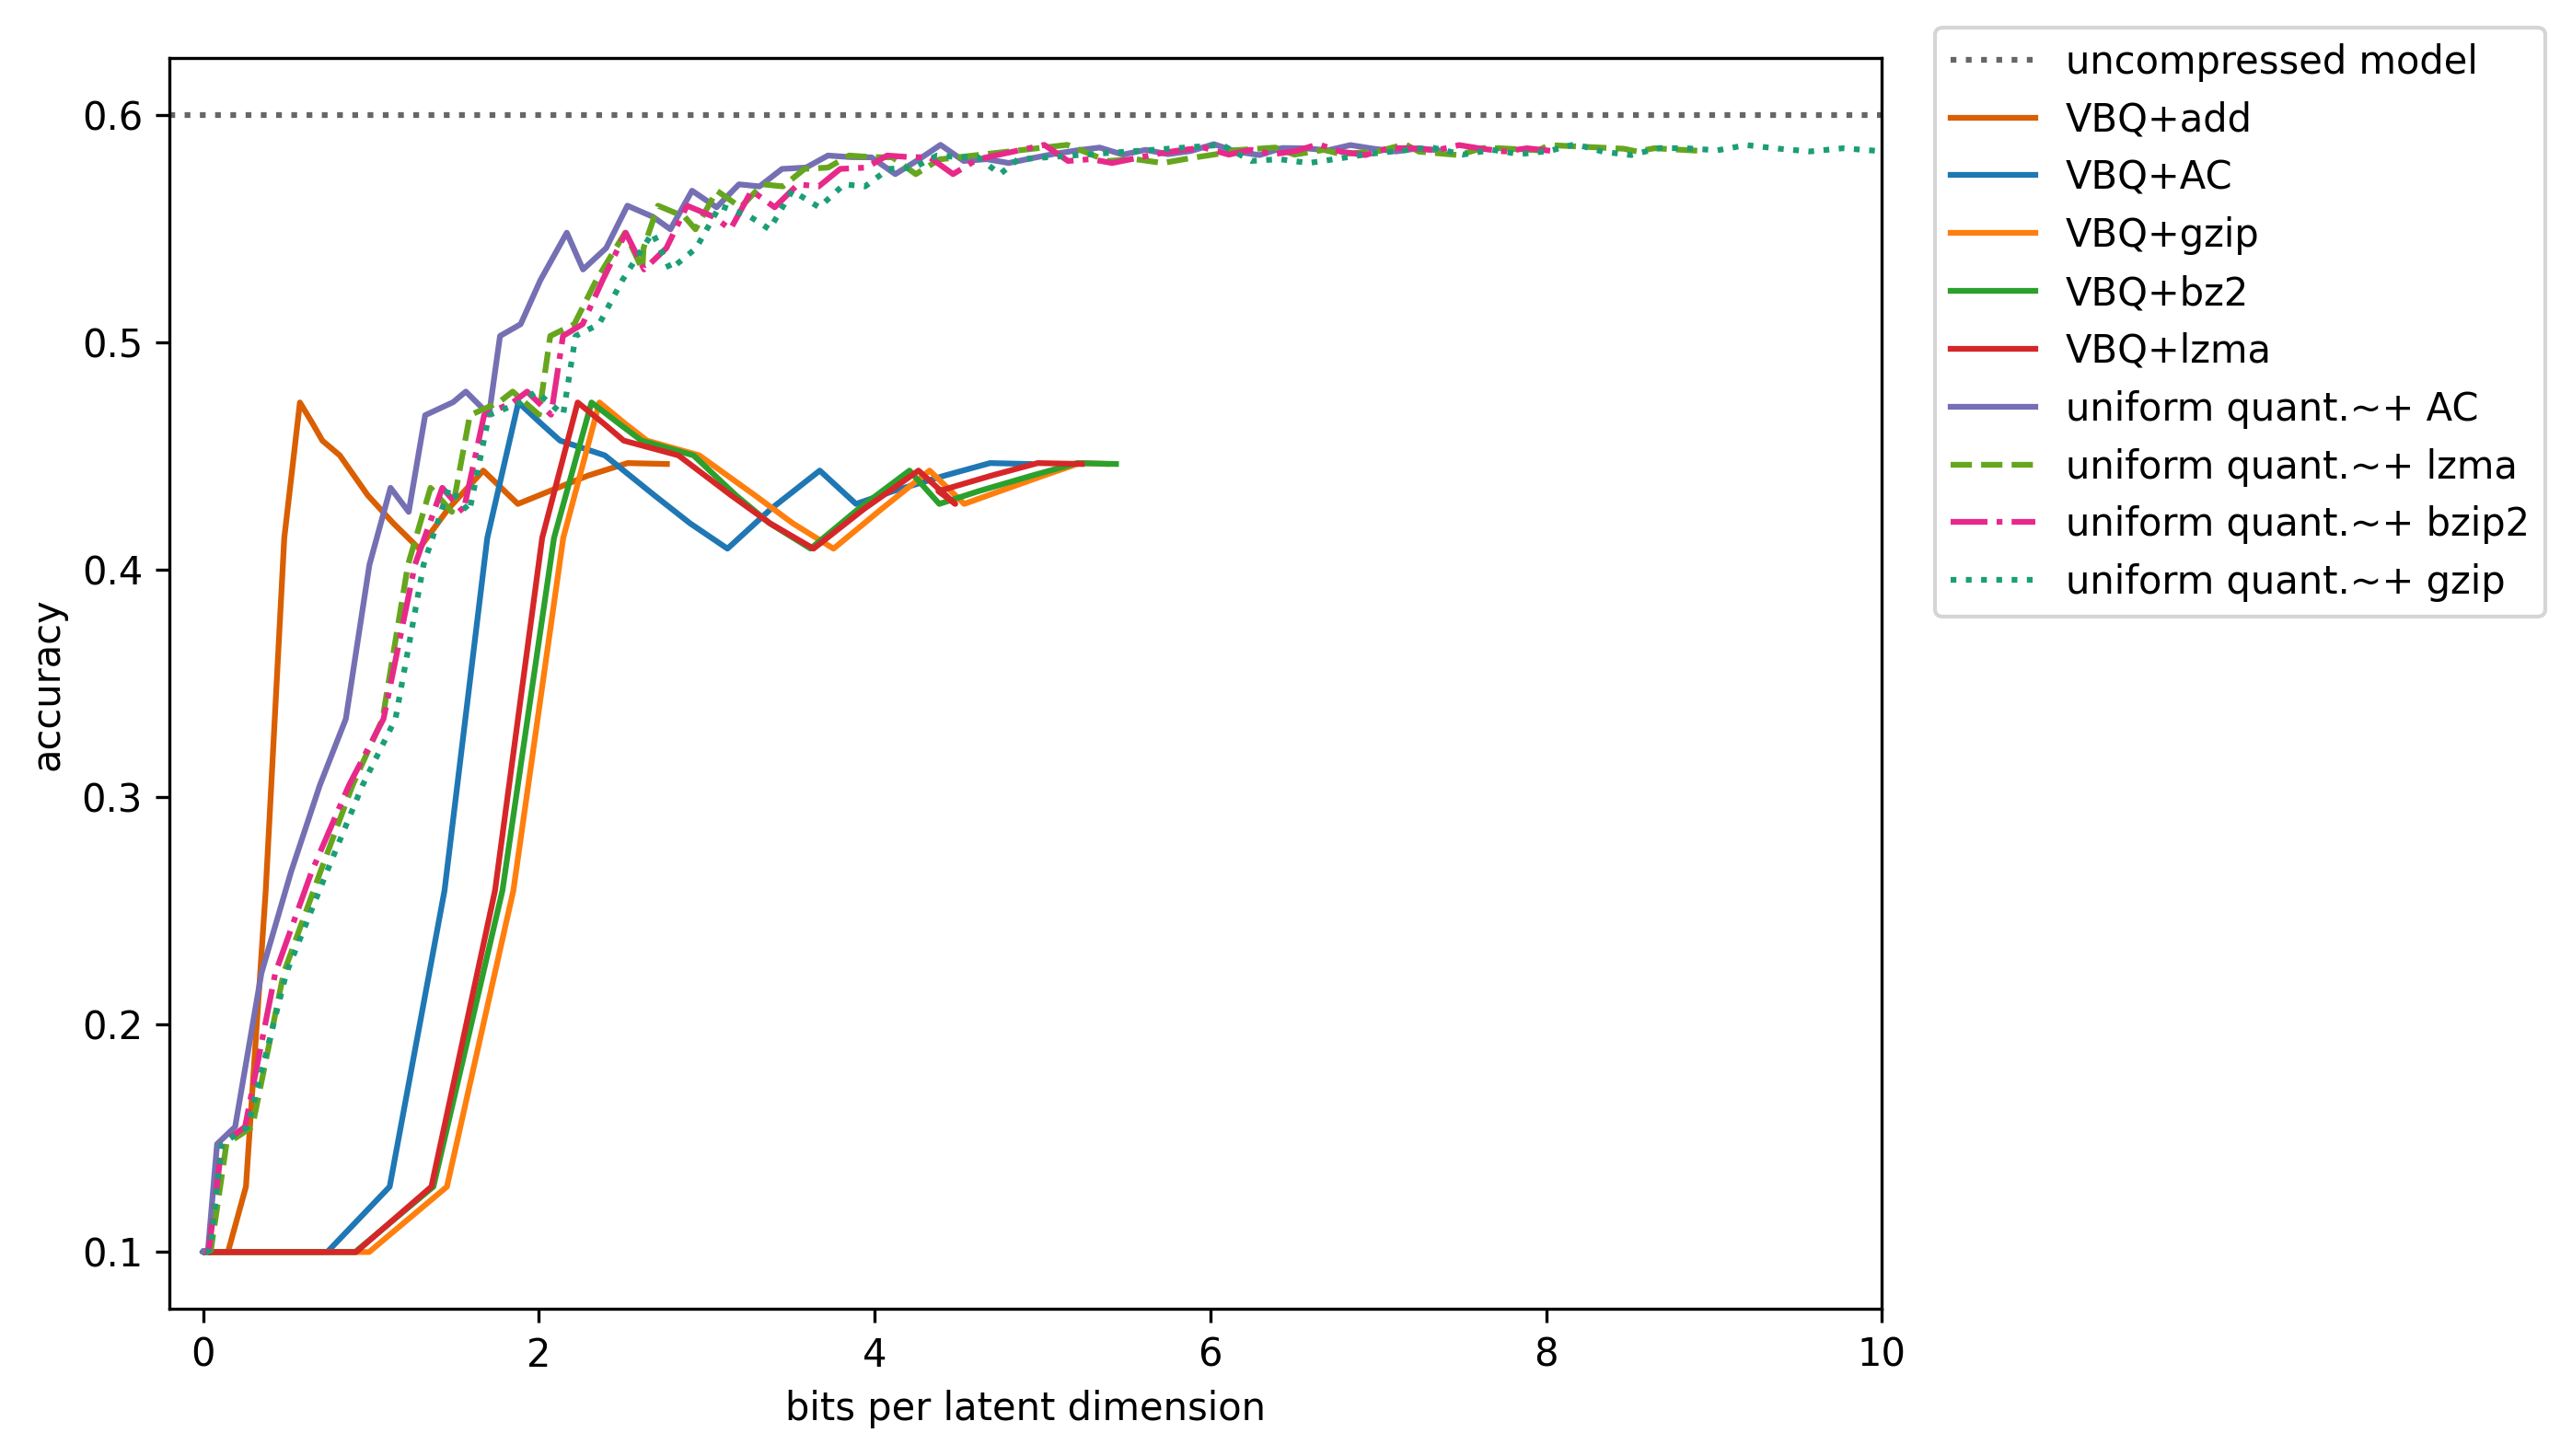

In [39]:
from matplotlib.ticker import AutoMinorLocator
plt.figure(figsize=(8, 6), dpi=300)
full_acc = 0.6
plt.axhline(full_acc, linestyle=':', color='#666666', label='uncompressed model')

num_dimensions = len(whole_w)

plt.plot(
    mrrs_and_bitlengths[:, 5] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+add', c='#d95f02')

plt.plot(
    mrrs_and_bitlengths[:, 1] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+AC')

plt.plot(
    mrrs_and_bitlengths[:, 2] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+gzip')

plt.plot(
    mrrs_and_bitlengths[:, 3] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+bz2')

plt.plot(
    mrrs_and_bitlengths[:, 4] / num_dimensions,
    mrrs_and_bitlengths[:, 0],
    '-', label='VBQ+lzma')

# plt.plot(
#     mrrs_and_bitlengths_baseline[:, -4] / num_dimensions,
#     mrrs_and_bitlengths_baseline[:, 0],
#     '-', label='uniform quant.~+ AC', c='#7570b3')


# plt.plot(
#     mrrs_and_bitlengths_baseline[:, -1] / num_dimensions,
#     mrrs_and_bitlengths_baseline[:, 0],
#     '--', label='uniform quant.~+ lzma',  c='#66a61e')

# plt.plot(
#     mrrs_and_bitlengths_baseline[:, -2] / num_dimensions,
#     mrrs_and_bitlengths_baseline[:, 0],
#     '-.', label='uniform quant.~+ bzip2',  c='#e7298a')

# plt.plot(
#     mrrs_and_bitlengths_baseline[:, -3] / num_dimensions,
#     mrrs_and_bitlengths_baseline[:, 0],
#      ':', label='uniform quant.~+ gzip', c='#1b9e77')

plt.plot(
    mrrs_and_bitlengths_baseline[:, 1] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-', label='uniform quant.~+ AC', c='#7570b3')


plt.plot(
    mrrs_and_bitlengths_baseline[:, 4] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '--', label='uniform quant.~+ lzma',  c='#66a61e')

plt.plot(
    mrrs_and_bitlengths_baseline[:, 3] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-.', label='uniform quant.~+ bzip2',  c='#e7298a')

plt.plot(
    mrrs_and_bitlengths_baseline[:, 2] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
     ':', label='uniform quant.~+ gzip', c='#1b9e77')

plt.xlim(-0.2, 10)
plt.xlabel('bits per latent dimension')
plt.ylabel('accuracy')
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.04), labelspacing=0.5, handlelength=2.2)


In [35]:
np.sort(mrrs_and_bitlengths[:, -2] / num_dimensions)

array([0.01509531, 0.01690159, 0.0241267 , 0.03573848, 0.05689772,
       0.10398994, 0.18849789, 0.35815889, 0.59916782, 0.91668548,
       1.29600361, 1.67235429, 2.02122375, 2.29848724, 2.50943457,
       2.67638616, 2.79508435, 2.96629358, 3.13943812, 3.34083798,
       3.53785118, 3.72815534, 3.92632971, 4.08115344, 4.18036964,
       4.26797407, 4.32009806, 4.34577299, 4.36164242, 4.36938361,
       4.3764797 , 4.37789891, 4.37828597, 4.37841499, 4.37841499,
       4.37854401, 4.37867303, 4.37893107, 4.37893107, 4.37983421,
       4.37983421, 4.37996323, 4.38035029, 4.38086637, 4.38125343,
       4.38254362, 4.38254362, 4.38254362, 4.38331774, 4.38770442])

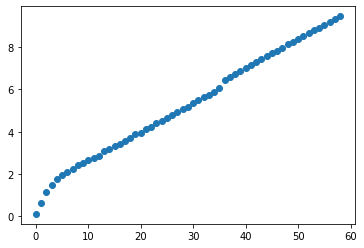

In [36]:
plt.plot(mrrs_and_bitlengths_baseline[:, -3] / num_dimensions, 'o')

In [66]:
uniform = test_quantization(4, 'global')[-1]

quantization_max=4
  Getting accuracy ...
acc: 0.95726836
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 25552
  gzip_bitlength = 29120
  bz2_bitlength  = 25424
  lzma_bitlength = 27976


In [67]:
Counter(uniform)

Counter({-0.0: 57982,
         -1.0: 1937,
         -2.0: 108,
         -3.0: 20,
         1.0: 1542,
         2.0: 69,
         4.0: 15,
         3.0: 23,
         -4.0: 10})

In [59]:
VBQ = compress_model(lamb=1, strategy='global', max_codepoint_length=3)[-1]

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [56]:
Counter(uniform).most_common()

[(-0.0, 52237),
 (-1.0, 4090),
 (1.0, 3085),
 (-2.0, 898),
 (2.0, 765),
 (-3.0, 238),
 (3.0, 148),
 (-4.0, 67),
 (4.0, 43),
 (-5.0, 31),
 (5.0, 22),
 (-6.0, 16),
 (6.0, 13),
 (-7.0, 10),
 (7.0, 10),
 (9.0, 7),
 (8.0, 6),
 (10.0, 6),
 (-10.0, 5),
 (-8.0, 5),
 (-9.0, 4)]

In [60]:
Counter(VBQ).most_common()

[(1, 23351),
 (2, 16488),
 (0, 11157),
 (4, 1743),
 (-2, 1517),
 (3, 1021),
 (-4, 1015),
 (6, 896),
 (7, 889),
 (5, 825),
 (-1, 786),
 (-3, 651),
 (-7, 529),
 (-6, 456),
 (-5, 382)]